In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
from sklearn import preprocessing
import wfdb
import copy as cp
import scipy.signal as signal
from scipy import stats
from sklearn import preprocessing
from tqdm import tqdm
import os
import re
import pandas as pd
import pickle
import csv

In [3]:
rlist = []
records = os.path.normpath('mit-bih-dataframes/subject_list.csv')
with open(records) as rfile:
    recordreader = csv.reader(rfile, delimiter=' ', quotechar='|')
    for row in recordreader:
        rlist.append(row[0])

In [4]:
subject_dfs = {}
for record in tqdm(rlist):
    subject_dfs[record] = pd.read_csv(os.path.normpath('mit-bih-extracted/'+record+'_full.csv'), index_col=[0,1])

100%|███████████████████████████████████████████| 23/23 [00:01<00:00, 12.01it/s]


In [4]:
##older outlier removal code, do not run
rr_ints = []

for subject in tqdm(subject_rr_rhythms):
    rr_ints.append(subject[(np.abs(stats.zscore(subject['rr_int'])) < 4)].reset_index(drop=True))

rr_ints[22].tail()

100%|██████████████████████████████████████████| 23/23 [00:00<00:00, 379.66it/s]


,rr_int,rr_int_seconds,rhythms
59475,173,0.692,A
59476,157,0.628,A
59477,68,0.272,A
59478,69,0.276,A
59479,53,0.212,A


In [5]:
def subset_subject(subjdf, interval_length = 25):
    if (len(subjdf) % interval_length != 0):
        slices = (len(subjdf) // interval_length) + 1
    else:
        slices = int(len(subjdf) / interval_length)

    subsetdf = []
    for x in tqdm(range(slices)):
        subsetdf.append(subjdf.iloc[interval_length*x:interval_length*x+interval_length].reset_index())
    return subsetdf

In [6]:
def extract_rmean(subjdf):
    rmeans = []
    for index, value in subjdf["rr_int"].items():
        if index==0:
            rmeans.append(value)
        else:
            rmeans.append(0.75*rmeans[index-1] + 0.25*value)
    
    return rmeans

In [7]:
for subject in rr_ints:
    subsets = subset_subject(subject)
    rmean_column = []
    for subset in subsets:
        rmean_column.extend(extract_rmean(subset))
    subject["rmean"] = rmean_column
    subject["rmean_seconds"] = subject["rmean"] / 250

print(rr_ints[0].head())

100%|█████████████████████████████████████| 2380/2380 [00:00<00:00, 6324.90it/s]


   rr_int  rr_int_seconds rhythms       rmean  rmean_seconds
0     139           0.556       N  139.000000       0.556000
1     158           0.632       N  143.750000       0.575000
2     226           0.904       N  164.312500       0.657250
3     145           0.580       N  159.484375       0.637938
4     144           0.576       N  155.613281       0.622453


In [8]:
for x in tqdm(range(len(rr_ints))):
    rr_ints[x].to_csv(os.path.normpath('mit-bih-extracted/'+rlist[x]+'_rr_rhythms.csv'))

100%|███████████████████████████████████████████| 23/23 [00:04<00:00,  5.49it/s]


In [25]:
def plot_time_plot(data, selection, column, nrows, ncols, title, xlabel, ylabel):
    plt.figure(figsize=(28, 16), constrained_layout=True)
    
    for idx, record in enumerate(selection):
        ax = plt.subplot(nrows, ncols, idx + 1)
        ax.set_title('Subject '+str(record), fontsize=28)
        ax.set_xlabel(xlabel, fontsize=24)
        ax.set_ylabel(ylabel, fontsize=24)
        ax.tick_params(labelsize=22)

        df = data[record]

        current = df['rhythmLabel'].iloc[0]
        lastidx = 0
        print("Plot "+str(idx+1)+", Subject "+str(record))
        for row in tqdm(df.itertuples()):
            pos = row.Index[0]
            if pos == len(df)-1:
                dataset=df.loc[lastidx:pos+1]
                if current == 'N':
                    ax.plot(dataset.index.get_level_values('timestamp'), dataset[column], color='darkcyan')
                elif current == 'A':
                    ax.plot(dataset.index.get_level_values('timestamp'), dataset[column], color='orange')
                else:
                    ax.plot(dataset.index.get_level_values('timestamp'), dataset[column], color='salmon')
            elif row.rhythmLabel == current:
                continue
            else:
                dataset=df.loc[lastidx:pos]
                if current == 'N':
                    ax.plot(dataset.index.get_level_values('timestamp'), dataset[column], color='darkcyan')
                elif current == 'A':
                    ax.plot(dataset.index.get_level_values('timestamp'), dataset[column], color='orange')
                else:
                    ax.plot(dataset.index.get_level_values('timestamp'), dataset[column], color='salmon')
                lastidx = pos
                current = row.rhythmLabel
        ax.axhline(y=df[df['rhythmLabel'] == 'N'][column].mean(), color="darkslategray", linestyle="--", linewidth=5)
        ax.axhline(y=df[df['rhythmLabel'] == 'A'][column].mean(), color="purple", linestyle="--", linewidth=5)
        ax.axhline(y=df[df['rhythmLabel'] == 'O'][column].mean(), color="darkred", linestyle="--", linewidth=5)

    plt.suptitle(title, fontsize=36)

    normal_patch = mpatches.Patch(color='darkcyan', label='Normal')
    afib_patch = mpatches.Patch(color='orange', label='Afib')
    other_patch = mpatches.Patch(color='salmon', label='Other')
    normal_mean_patch = mpatches.Patch(color='darkslategray', label='Normal mean')
    afib_mean_patch = mpatches.Patch(color='purple', label='Afib mean')
    other_mean_patch = mpatches.Patch(color='darkred', label='Other mean') 
    plt.figlegend(handles=[normal_patch, afib_patch, other_patch, normal_mean_patch, afib_mean_patch, other_mean_patch], 
                #['Normal', 'Afib', 'Other', 'Normal mean', 'Afib mean', 'Other mean'],
                fontsize=28, 
                loc = "upper right",
                ncol=2,
                shadow = True)

Plot 1, Subject 04015


42819it [00:00, 52527.89it/s]


Plot 2, Subject 04936


53589it [00:03, 17249.99it/s]


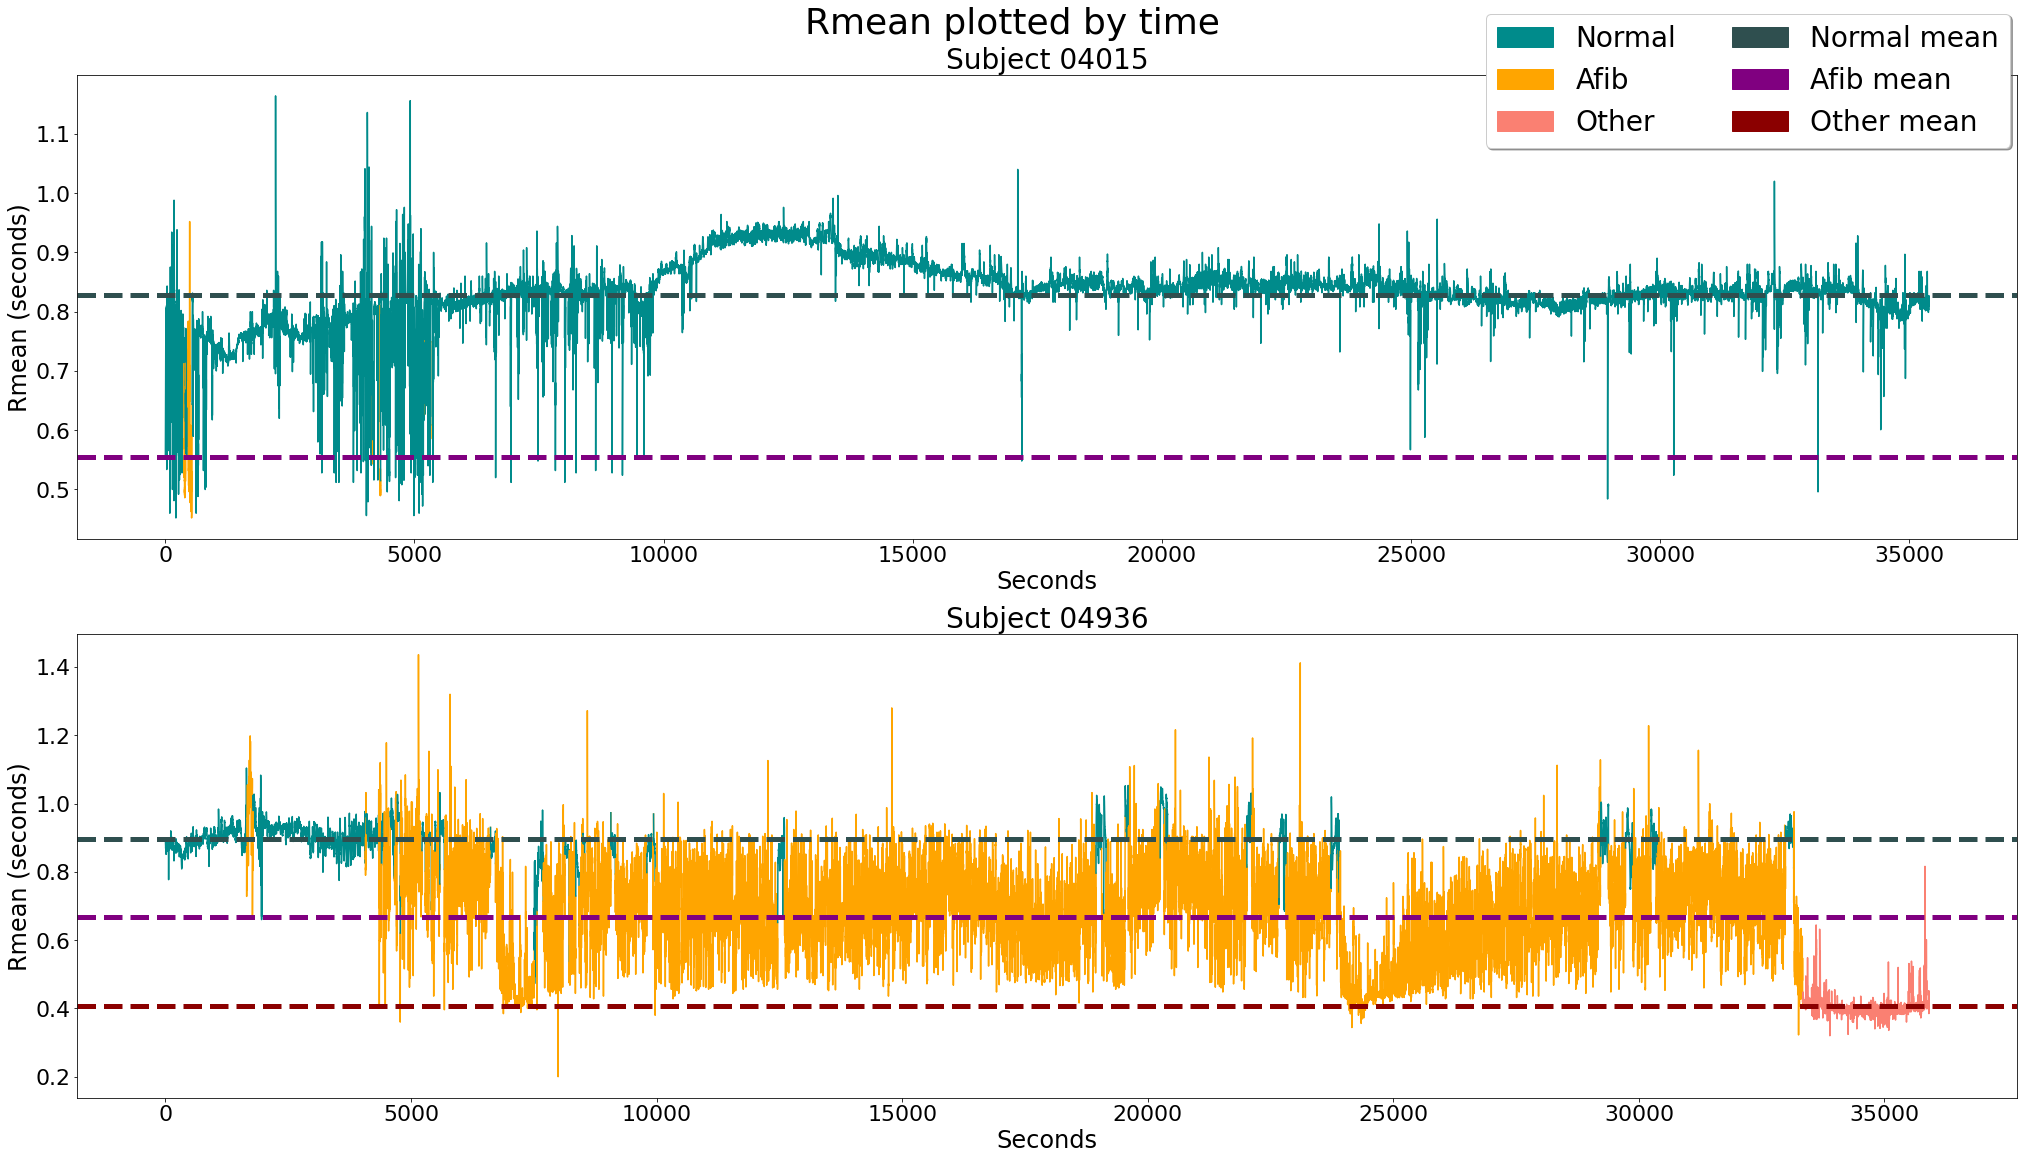

: 

In [27]:
plot_time_plot(subject_dfs, ['04015', '04936'], 'rmean_seconds', 2, 1, 'Rmean plotted by time', 'Seconds', 'Rmean (seconds)')